In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style="darkgrid"); sns.set_context('notebook')
import numpy as np

from sklearn.cluster import KMeans

from highstreets.data import make_dataset as mhsd
from highstreets.visualisation import visualise as vhsd

from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv())

YOY_FILE  = os.environ.get("YOY_FILE")
PROFILE_FILE = os.environ.get("PROFILE_FILE")
PROJECT_ROOT = os.environ.get("PROJECT_ROOT")

#### Load mastercard spend data along with high street profiles 

In [4]:
hsp = pd.read_excel(PROFILE_FILE)
hsd_yoy = pd.read_csv(YOY_FILE, parse_dates=['week_start'])

### Setup data arrays:

In [5]:
hsd_yoy_minimal = mhsd.avg_retail_wd_we(hsd_yoy, 'yoy_')

dates_2020 = ('2020-04-15','2020-10-31')
dates_2020_full = ('2020-01-01','2020-12-31')
dates_2021 = ('2021-02-12', '2021-08-31')
dates_full = ('2020-01-01','2021-12-31')

data_2020 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020, 'txn_amt')
data_2021 = mhsd.extract_data_array(hsd_yoy_minimal, dates_2021, 'txn_amt')
data_2020_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_2020_full, 'txn_amt')
data_full = mhsd.extract_data_array(hsd_yoy_minimal, dates_full, 'txn_amt')

### Run k-means on 2020, 2021, and full data separately:

In [6]:
n_clus = 3
max_iter = 50
tol = 1e-2

# 2020 data:
kmeans20 = KMeans(init='random', n_clusters=n_clus, 
    random_state=None, max_iter=max_iter, tol=tol, copy_x = True, verbose=0, n_init=10)
kmeans20.fit(np.transpose(data_2020.to_numpy()))

# 2021 data:
kmeans21 = KMeans(init='random', n_clusters=n_clus, 
    random_state=None, max_iter=max_iter, tol=tol, copy_x = True, verbose=0, n_init=10)
kmeans21.fit(np.transpose(data_2021.to_numpy()))

# full data:
kmeansfull = KMeans(init='random', n_clusters=n_clus, 
    random_state=None, max_iter=max_iter, tol=tol, copy_x = True, verbose=0, n_init=10)
kmeansfull.fit(np.transpose(data_full.to_numpy()))

KMeans(init='random', max_iter=50, n_clusters=3, tol=0.01)

## Regressions: trying to summarise trends across time

In [7]:
# Unpooled regression - fit slope and intercept independently for each high street
start_times = {'2020':'2020-04-01','2021':'2021-04-12','full':'2020-04-01'}
tvecs = {'2020':data_2020.index,'2021':data_2021.index,'full':data_full.index}
arrays = {'2020':np.transpose(data_2020.to_numpy()),'2021':np.transpose(data_2021.to_numpy()),'full':np.transpose(data_full.to_numpy())}

fit_lines = {}
reg_model={}

reg_model['2020'],fit_lines['2020'] = mhsd.get_fit_lines(start_times['2020'],tvecs['2020'],arrays['2020'], robust=False)
reg_model['2021'],fit_lines['2021'] = mhsd.get_fit_lines(start_times['2021'],tvecs['2021'],arrays['2021'], robust=False)
reg_model['full'],fit_lines['full'] = mhsd.get_fit_lines(start_times['full'],tvecs['full'],arrays['full'], robust=False)

### Plot each highstreet with lines fit to each recovery period

In [ ]:
vhsd.plot_all_profiles_full({'2020':data_2020,'2021':data_2021,'full':data_full},fit_lines)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/conor/miniconda3/envs/highstreets/lib/python3.10/site-packages/matplotlib/axis.py", line 1506, in convert_units
    ret = self.converter.convert(x, self.units, self)
  File "/home/conor/miniconda3/envs/highstreets/lib/python3.10/site-packages/matplotlib/dates.py", line 1920, in convert
    return self._get_converter().convert(*args, **kwargs)
  File "/home/conor/miniconda3/envs/highstreets/lib/python3.10/site-packages/matplotlib/dates.py", line 1849, in convert
    return date2num(value)
  File "/home/conor/miniconda3/envs/highstreets/lib/python3.10/site-packages/matplotlib/dates.py", line 442, in date2num
    tzi = getattr(d[0], 'tzinfo', None)
IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/conor/miniconda3/envs/highstreets/lib/python3.10/site-packages/IPython/core/interactiveshell.p

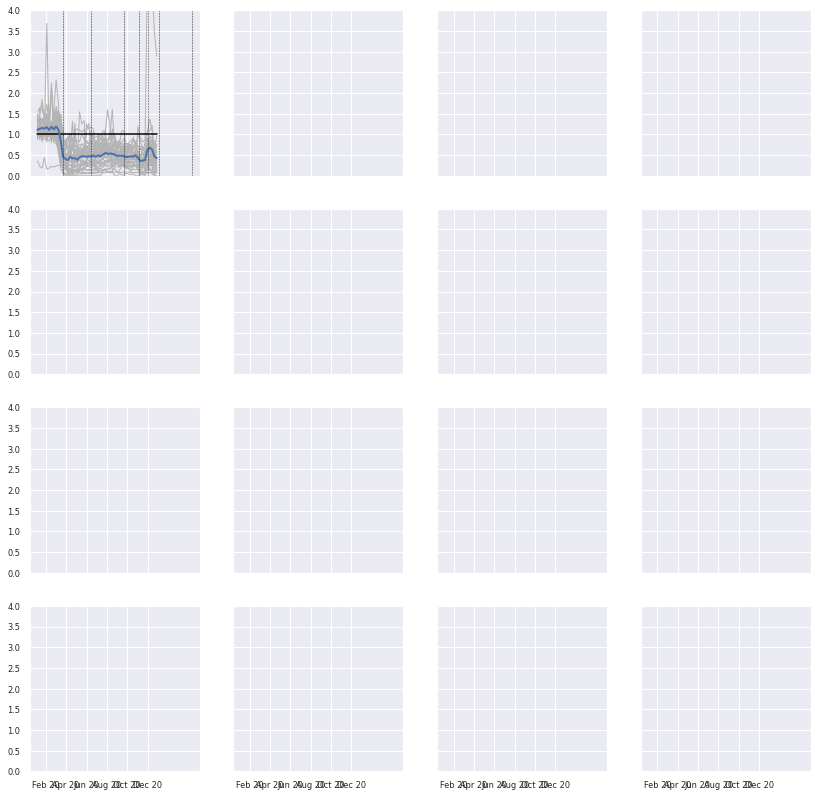

In [67]:
nb_dates = pd.to_datetime(['2020-03-24','2020-06-15','2020-09-22','2020-11-05','2020-12-02','2021-01-05','2021-04-12'])

# columns by which we will sort the highstreets (for example, slope of the best fit line to 2020 recovery and the initial hit in 2020)
#sort_cols = data_2020_full.loc['2020-04-01':'2020-04-30',:].min().to_numpy(), reg_model['2020'].coef_
sort_cols = data_2020_full.loc['2020-03-14':'2020-11-01',:].mean().to_numpy(), reg_model['2020'].coef_

# prepend mean and fit slopes to array for sorting and grouping:
plot_array = np.transpose(data_2020_full.to_numpy())
plot_tvec = data_2020_full.index
filename = 'banner.png'

vhsd.plot_highstreets_grouped(plot_array, plot_tvec, sort_cols, nb_dates, filename)
